<a href="https://colab.research.google.com/github/8Ishita8/Assignment-2/blob/main/AIML_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b90ead232b225275bda58accd993fee04a5980fa704c4484a5270b7a8f4f9a4a
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving co2_emission.csv to co2_emission.csv



Missing values in each column:
Country                                   0
Continent                                 0
Hemisphere                                0
Metric tons of CO2e per capita (1990)    27
Metric tons of CO2e per capita (1995)     4
Metric tons of CO2e per capita (2000)     2
Metric tons of CO2e per capita (2005)     2
Metric tons of CO2e per capita (2010)     0
Metric tons of CO2e per capita (2013)     1
Metric tons of CO2e per capita (2018)     1
dtype: int64

Training and evaluating Linear Regression model...
MAE: 1.6095, MSE: 10.2907, R^2: 0.5893

Training and evaluating Random Forest model...
MAE: 1.4290, MSE: 15.6394, R^2: 0.3758

Training and evaluating Gradient Boosting model...
MAE: 1.5238, MSE: 16.9270, R^2: 0.3244


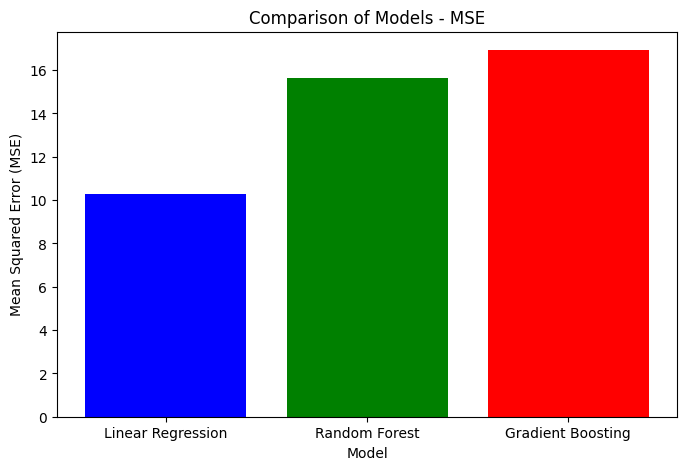

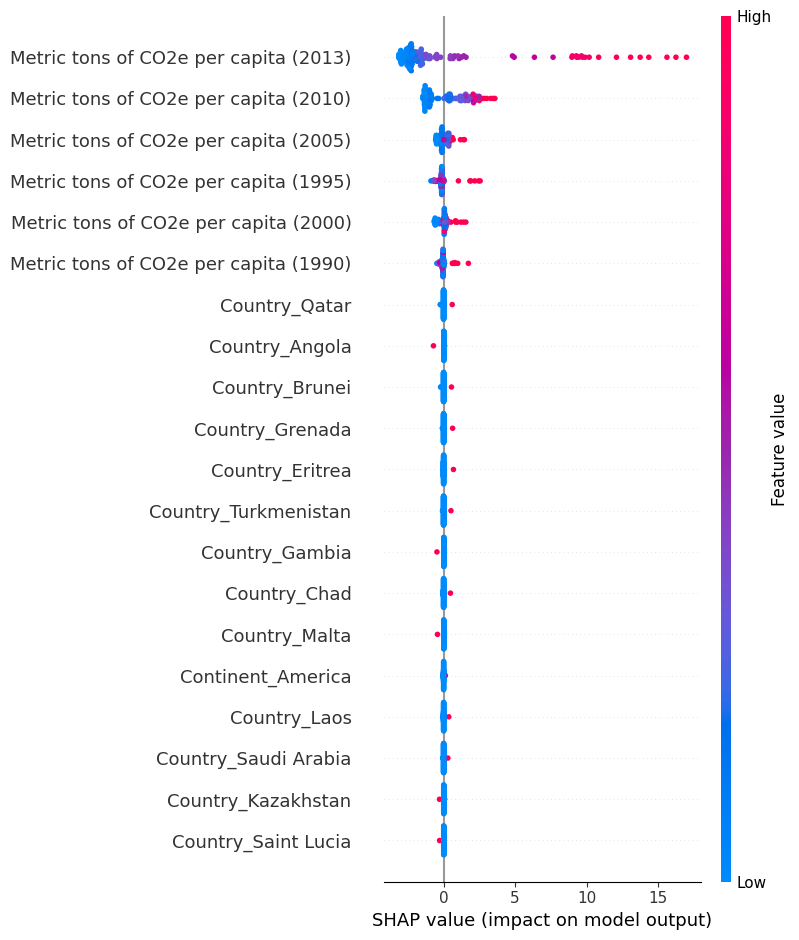

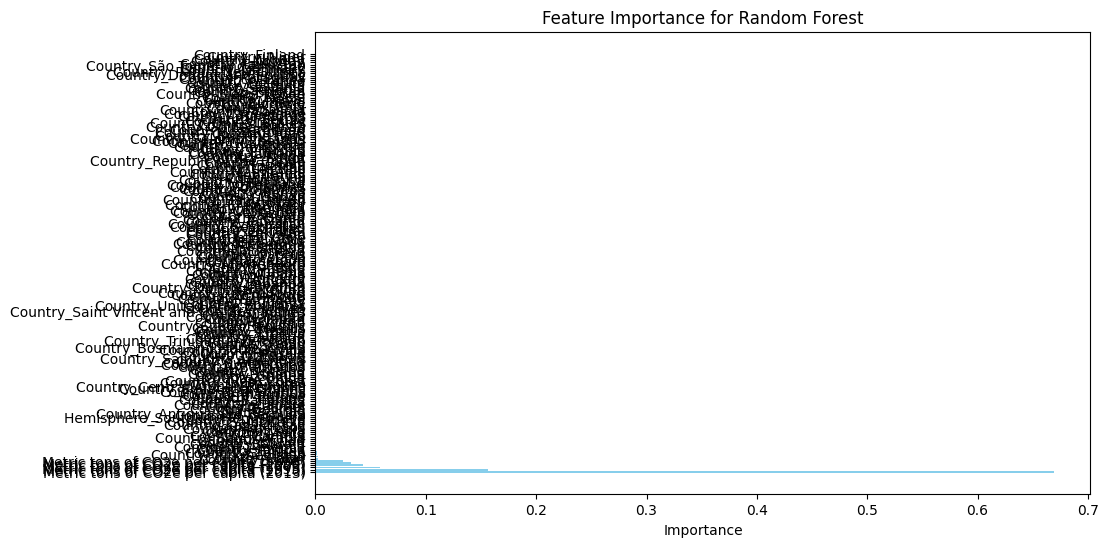

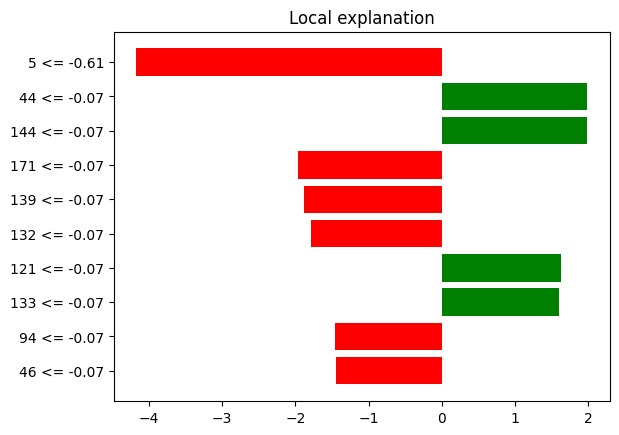

In [ ]:
import pandas as pd
import numpy as np
import shap
import lime
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

# Load the dataset
df = pd.read_csv("co2_emission.csv")

# Step 1: Data Preprocessing
print("\nMissing values in each column:")
print(df.isnull().sum())

# Impute missing values
imputer = SimpleImputer(strategy='mean')
df[df.select_dtypes(include=np.number).columns] = imputer.fit_transform(df.select_dtypes(include=np.number))

# Step 2: Define features (X) and target (y)
df = pd.get_dummies(df, columns=['Country', 'Continent', 'Hemisphere'], drop_first=True)  # Encoding categorical variables
X = df.drop(columns=['Metric tons of CO2e per capita (2018)'])
y = df['Metric tons of CO2e per capita (2018)']

# Step 3: Data Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Step 6: Train and evaluate models using cross-validation
results = {}
for name, model in models.items():
    print(f"\nTraining and evaluating {name} model...")
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = -cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    results[name] = {
        'CV Mean MSE': np.mean(cv_scores),
        'CV Standard Deviation': np.std(cv_scores)
    }

    # Fit model and evaluate on test data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name]['MAE'] = mae
    results[name]['MSE'] = mse
    results[name]['R^2'] = r2
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, R^2: {r2:.4f}")

# Step 7: Visualize results
models_names = list(results.keys())
mse_values = [results[model]['MSE'] for model in models_names]

plt.figure(figsize=(8, 5))
plt.bar(models_names, mse_values, color=['blue', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of Models - MSE')
plt.show()

# XAI: SHAP, LIME and Feature Importance

# Select Random Forest model for XAI explanation
model_name = 'Random Forest'
model = models[model_name]

# SHAP Explainer for Tree-based models (Random Forest)
explainer = shap.TreeExplainer(model)

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_train, feature_names=X.columns)

# Feature Importance Plot (from Random Forest)
if isinstance(model, RandomForestRegressor):
    feature_importances = model.feature_importances_
elif isinstance(model, GradientBoostingRegressor):
    feature_importances = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the feature importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Feature Importance for {model_name}')
plt.show()

# LIME: Local Interpretability for a Specific Prediction
# Remove 'training_mode='regression''
explainer = LimeTabularExplainer(X_train, training_labels=y_train, mode='regression')

# Choose an instance to explain (e.g., index 36)
i = 36  # Example instance index
exp = explainer.explain_instance(X_test[i], model.predict)

# Visualize the explanation
exp.as_pyplot_figure()
plt.show()

